<a href="https://colab.research.google.com/github/aaldayarova/house-prices/blob/main/housing_prices_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'house-prices-advanced-regression-techniques:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F5407%2F868283%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240916%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240916T161116Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1bde4332fe80d5f42eaf971d998c190006acf0479e31f38961b32ad95821cb378f4fb5106f4017aedfcadc2926fccc1570c1163eaf44fee1f246ee454699399bf71c85b039f0d7f5fe371a14fbf32e7e205791fa00b19348ca63ed2f55ce9512588304ffc05d6f1764dd521dce869cc17332d06df5f59accba711619fe074ba5e40e9389274d0b9d8e6f9defcb5453263d9ce42cb2efb3f46d87c7195cc6de8be836689859669af1e8f209458696e350957ff4686955a8898ca07594bd505590b20da00e1b5e4dd8ba11218e6c8f0eb810d4df21d8e8f88161775766fe888d2064bcae5d7585b3517f472314ad8cf080255a425705011f9b1505db790f631a52'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 203809 bytes downloaded
Downloaded and uncompressed: house-prices-advanced-regression-techniques
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


In [ ]:
# Creating dataframes for train and test data
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
# Defining our categorical variable (BldgType)
categorical_data = train_data['BldgType']
categorical_data.head()

,BldgType
0,1Fam
1,1Fam
2,1Fam
3,1Fam
4,1Fam


(array([1220.,    0.,   31.,    0.,    0.,   52.,    0.,  114.,    0.,
          43.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

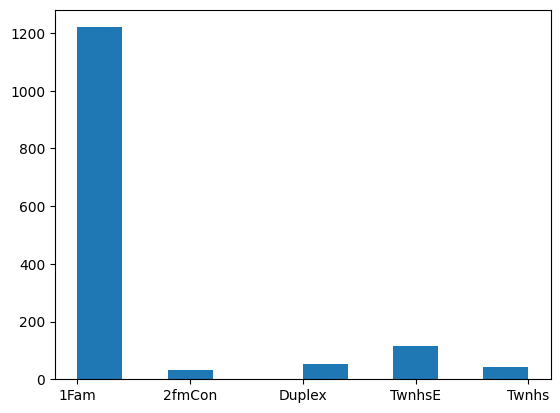

In [ ]:
# Histogram of categorical variable (BldgType)
plt.hist(categorical_data)

In [ ]:
# Defining our continuous variable (LotArea)
continuous_data = train_data['LotArea']
continuous_data.head()

,LotArea
0,8450
1,9600
2,11250
3,9550
4,14260


(array([185., 907., 294.,  38.,  13.,   5.,   5.,   1.,   2.,   4.]),
 array([    0.,  5800., 11600., 17400., 23200., 29000., 34800., 40600.,
        46400., 52200., 58000.]),
 <BarContainer object of 10 artists>)

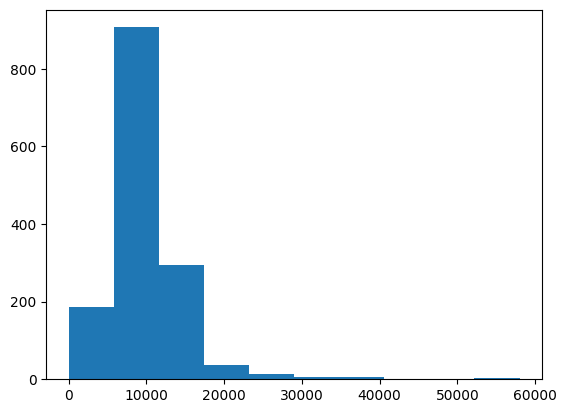

In [ ]:
# Historgram of continuous variable (LotArea)
plt.hist(continuous_data, range = (0, 58000))


# **Pre-processing data**

In [ ]:
# Drop unnecessary columns
train_data = train_data.drop(['LotFrontage', 'LotArea', 'LotShape', 'Alley', 'LandContour', 'Utilities', 'Street', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'BsmtCond', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenAbvGr', 'Functional', 'PavedDrive', 'GarageCond', 'GarageQual', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'], axis=1)
test_data = test_data.drop(['LotFrontage', 'LotArea', 'LotShape', 'Alley', 'LandContour', 'Utilities', 'Street', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'RoofMatl', 'BsmtCond', 'BsmtFinSF2', 'Heating', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenAbvGr', 'Functional', 'PavedDrive', 'GarageCond', 'GarageQual', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'], axis=1)

In [ ]:
# Drop rows with NA values
train_data_dropped = train_data.dropna()
test_data_dropped = test_data.dropna()

In [ ]:
# One-hot encoding for a categorical value (BldgType)
# Source: https://www.kdnuggets.com/2023/07/pandas-onehot-encode-data.html
encoded_train_data = pd.get_dummies(train_data_dropped, columns=['BldgType',])
encoded_test_data = pd.get_dummies(test_data_dropped, columns=['BldgType',])

In [ ]:
# See the new categories created
print(encoded_train_data.columns.tolist())
# encoded_train_data.head()

['Id', 'MSSubClass', 'MSZoning', 'Neighborhood', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'PoolArea', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs', 'BldgType_TwnhsE']


In [ ]:
# Further refine fields we will use for OLS
ols_train_dataset = encoded_train_data.drop(['Id', 'MSSubClass', 'MSZoning', 'HouseStyle', 'OverallQual', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageArea', 'SaleType', 'SaleCondition'], axis=1)
ols_test_dataset = encoded_test_data.drop(['Id', 'MSSubClass', 'MSZoning', 'HouseStyle', 'OverallQual', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtUnfSF', 'HeatingQC', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'BedroomAbvGr', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageArea', 'SaleType', 'SaleCondition'], axis=1)
pd.set_option('display.max_columns', None)
ols_train_dataset_encoded = pd.get_dummies(ols_train_dataset, columns=['Neighborhood', 'ExterCond', 'BsmtQual', ])
ols_test_dataset_encoded = pd.get_dummies(ols_test_dataset, columns=['Neighborhood', 'ExterCond', 'BsmtQual', ])
display(ols_train_dataset_encoded)

,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea,MoSold,YrSold,SalePrice,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA
2,5,2001,2002,486,920,920,866,2,1,6,1,2,0,42,0,0,9,2008,223500,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
4,5,2000,2000,655,1145,1145,1053,2,1,9,1,3,192,84,0,0,12,2008,250000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
6,5,2004,2005,1369,1686,1694,0,2,0,7,1,2,255,57,0,0,8,2007,307000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False
7,6,1973,1973,859,1107,1107,983,2,1,7,2,2,235,204,228,0,11,2009,200000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
11,5,2005,2006,998,1175,1182,1142,3,0,11,2,3,147,21,0,0,7,2006,345000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,5,2004,2004,697,848,848,0,1,0,3,1,2,149,0,0,0,5,2008,149300,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1442,5,2008,2008,765,1017,1026,981,2,1,10,1,3,168,52,0,0,4,2009,310000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False
1447,5,1995,1996,1079,1220,1220,870,2,1,8,1,2,0,65,0,0,12,2007,240000,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1451,5,2008,2009,0,1573,1578,0,2,0,7,1,3,0,36,0,0,5,2009,287090,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False


In [ ]:
# copy the data
train_min_max_scaled = ols_train_dataset_encoded.copy()
test_min_max_scaled = ols_test_dataset_encoded.copy()

# function for normalizing the data using min max scaling
def minMaxScale(df, column):
  df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())


In [ ]:
#Normalizing the training Data
minMaxScale(train_min_max_scaled, "YearBuilt")
minMaxScale(train_min_max_scaled, "YearRemodAdd")
minMaxScale(train_min_max_scaled, "BsmtFinSF1")
minMaxScale(train_min_max_scaled, "TotalBsmtSF")
minMaxScale(train_min_max_scaled, "1stFlrSF")
minMaxScale(train_min_max_scaled, "2ndFlrSF")
minMaxScale(train_min_max_scaled, "FullBath")
minMaxScale(train_min_max_scaled, "HalfBath")
minMaxScale(train_min_max_scaled, "TotRmsAbvGrd")
minMaxScale(train_min_max_scaled, "Fireplaces")
minMaxScale(train_min_max_scaled, "GarageCars")
minMaxScale(train_min_max_scaled, "WoodDeckSF")
minMaxScale(train_min_max_scaled, "OpenPorchSF")
minMaxScale(train_min_max_scaled, "EnclosedPorch")
minMaxScale(train_min_max_scaled, "PoolArea")
minMaxScale(train_min_max_scaled, "MoSold")
minMaxScale(train_min_max_scaled, "YrSold")
minMaxScale(train_min_max_scaled, "OverallCond")

# view normalized data
display(train_min_max_scaled)

,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea,MoSold,YrSold,SalePrice,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,ExterCond_Fa,ExterCond_Gd,ExterCond_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA
2,0.428571,0.886076,0.866667,0.086109,0.093608,0.103825,0.462607,0.666667,0.5,0.333333,0.0,0.333333,0.000000,0.103448,0.000000,0.0,0.727273,0.50,223500,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
4,0.428571,0.873418,0.833333,0.116052,0.132903,0.157282,0.562500,0.666667,0.5,0.666667,0.0,0.666667,0.287425,0.206897,0.000000,0.0,1.000000,0.50,250000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
6,0.428571,0.924051,0.916667,0.242558,0.227384,0.287717,0.000000,0.666667,0.0,0.444444,0.0,0.333333,0.381737,0.140394,0.000000,0.0,0.636364,0.25,307000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False
7,0.571429,0.531646,0.383333,0.152197,0.126266,0.148254,0.525107,0.666667,0.5,0.444444,0.5,0.333333,0.351796,0.502463,0.863636,0.0,0.909091,0.75,200000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
11,0.428571,0.936709,0.933333,0.176825,0.138142,0.166073,0.610043,1.000000,0.0,0.888889,0.5,0.666667,0.220060,0.051724,0.000000,0.0,0.545455,0.00,345000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,0.428571,0.924051,0.900000,0.123494,0.081034,0.086719,0.000000,0.333333,0.0,0.000000,0.0,0.333333,0.223054,0.000000,0.000000,0.0,0.363636,0.50,149300,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1442,0.428571,0.974684,0.966667,0.135542,0.110548,0.129009,0.524038,0.666667,0.5,0.777778,0.0,0.666667,0.251497,0.128079,0.000000,0.0,0.272727,0.75,310000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False
1447,0.428571,0.810127,0.766667,0.191176,0.146001,0.175101,0.464744,0.666667,0.5,0.555556,0.0,0.333333,0.000000,0.160099,0.000000,0.0,1.000000,0.25,240000,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
1451,0.428571,0.974684,0.983333,0.000000,0.207649,0.260157,0.000000,0.666667,0.0,0.444444,0.0,0.666667,0.000000,0.088670,0.000000,0.0,0.36363

In [ ]:
#Normalizing the testing data
minMaxScale(test_min_max_scaled, "YearBuilt")
minMaxScale(test_min_max_scaled, "YearRemodAdd")
minMaxScale(test_min_max_scaled, "BsmtFinSF1")
minMaxScale(test_min_max_scaled, "TotalBsmtSF")
minMaxScale(test_min_max_scaled, "1stFlrSF")
minMaxScale(test_min_max_scaled, "2ndFlrSF")
minMaxScale(test_min_max_scaled, "FullBath")
minMaxScale(test_min_max_scaled, "HalfBath")
minMaxScale(test_min_max_scaled, "TotRmsAbvGrd")
minMaxScale(test_min_max_scaled, "Fireplaces")
minMaxScale(test_min_max_scaled, "GarageCars")
minMaxScale(test_min_max_scaled, "WoodDeckSF")
minMaxScale(test_min_max_scaled, "OpenPorchSF")
minMaxScale(test_min_max_scaled, "EnclosedPorch")
minMaxScale(test_min_max_scaled, "PoolArea")
minMaxScale(test_min_max_scaled, "MoSold")
minMaxScale(test_min_max_scaled, "YrSold")
minMaxScale(test_min_max_scaled, "OverallCond")

In [ ]:
# Dropping one of each OHE columns to avoid a singular matrix error
ols_training = train_min_max_scaled.drop(['Neighborhood_Blmngtn', 'BldgType_1Fam', 'BldgType_2fmCon', 'ExterCond_Fa', 'BsmtQual_Ex'], axis=1)
ols_testing = test_min_max_scaled.drop(['Neighborhood_Blmngtn', 'BldgType_1Fam', 'ExterCond_Fa', 'BsmtQual_Ex'], axis=1)

(array([337.,   0.,  40.,   0.,   0.,   6.,   0.,   1.,   0.,   2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

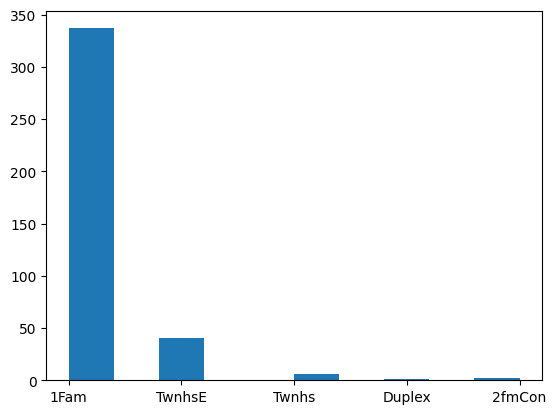

In [ ]:
# Visualizing BldgType in pre-processed dataset without OHE...
categorical_data_new = train_data_dropped['BldgType']
# categorical_data_new.head()
plt.hist(categorical_data_new)

(array([[ 49.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 337.],
        [346.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  40.],
        [380.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.],
        [385.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 4 BarContainer objects>)

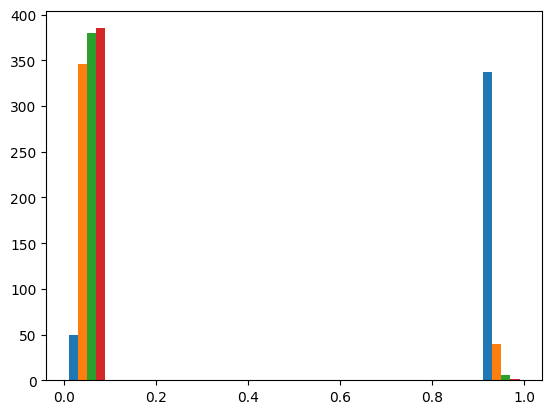

In [ ]:
# ...and now with OHE
# Note: each bar color represents a building type; bars at 1 represent count of True values, and bars at 0 represent count of False values
encoded_categorical_data_new = encoded_train_data[['BldgType_1Fam', 'BldgType_TwnhsE', 'BldgType_Twnhs', 'BldgType_Duplex']]
plt.hist(encoded_categorical_data_new.astype(int))


In [ ]:
# Implementing OLS (finding our best theta parameters)

X_train = ols_training.drop('SalePrice', axis=1).astype(float)
y_train = ols_training['SalePrice']

theta_best = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
theta_best_df = pd.DataFrame(data=theta_best[np.newaxis, :], columns=X_train.columns)
theta_best_df

,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,PoolArea,MoSold,YrSold,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,ExterCond_Gd,ExterCond_TA,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA
0,70599.738884,33764.248821,7672.146414,81722.777337,17501.59107,160330.384568,27617.987601,57103.499661,13100.210547,81676.733919,35810.735109,55984.669391,16773.522037,-28351.06942,10296.106545,-117782.365208,-1156.920026,-3017.141944,-38354.590707,-28670.671025,-10288.166932,12466.179329,2710.676266,37295.259536,31005.746607,30703.834705,-61115.888071,14763.235817,61293.385443,-7689.636029,-15674.404704,-12261.670362,76475.074953,55719.610301,-13365.619262,1764.9872,-25083.931577,22441.952325,25659.044175,106930.537536,15943.518713,-20148.793757,35734.60399,41924.075613,-62375.472141,-50368.726482,-32760.27749


In [ ]:
# Evaluating predictions on training set using R^2 score
metrics.r2_score(y_train, X_train.dot(theta_best))

0.7848885900511742

In [ ]:
# Evaluating predictions on training set using MSE score
metrics.mean_squared_error(y_train, X_train.dot(theta_best))

1870475297.1581392

In [ ]:
# Using our theta approximations, we can now compute predictions on new data points
X_test = ols_testing.astype(float)

# Generate predictions on the new houses
y_test_pred = X_test.dot(theta_best)

#view predictions
y_test_pred

,0
3,103042.989109
15,218381.753245
17,185728.537774
18,191033.945225
19,288556.528983
...,...
1435,146174.598593
1442,204230.435694
1443,138146.643917
1451,22897.515730


In [ ]:
# Outputting predictions into submissions.csv file
submission_df = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': y_test_pred})
submission_df['SalePrice'] = submission_df['SalePrice'].fillna(0.0)
submission_df.to_csv('submissions.csv', index=False)